# SpecUFEx Tutorial: The Geysers, California

Written by Theresa Sawi and Nate Groebner

Based on the study **Machine learning reveals cyclic changes in seismic source spectra in Geysers geothermal field** by Holtzman et al., 2018. DOI 10.1126/sciadv.aao2929

This example walks through fitting a SpecUFEx model to seismograms of approximately 5,000 microearthquakes from The Geysers geothermal field in California from 2012 to 2014. This is a subset of the 46,000 events that were analyzed in the study above. Using the features extracted by SpecUFEx, k-means clustering identifies 4 clusters of earthquake patterns that are correlated to rate of water flow into the injection wells.

## Tutorial Steps

1. Read in waveforms from hdf5 file.
2. Convert waveforms to spectrograms (filtered and median normalized)
3. Run SpecUFEx on spectrograms: Nonnegative matrix factorization followed by hidden markov model
4. Do kmeans clustering on SpecUFEx fingerprints
5. Compare clusters to paper figure 3c



### Imports

In [1]:
import datetime
import glob
import os
import h5py
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from io import StringIO
import scipy.signal as sp
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import trange
import obspy
from specufex import BayesianNonparametricNMF, BayesianHMM
import glob
import xml.etree.ElementTree as ET
import random
from tqdm import tqdm


# Set params

In [2]:
station_name = "T1214"
network = "IV"

freq_min, freq_max= 1,40
preroll = 3 #seconds before P wave
postroll = 17 #seconds after P wave
num_samp = 1000 #number of samples for test run


# Load station info


In [3]:

# Namespace dictionary
namespaces = {'ns': 'http://www.fdsn.org/xml/station/1'}


xml_iv = glob.glob('./data/amatrice/stations/IV/*.xml')
xml_yr = glob.glob('./data/amatrice/stations/YR/*.xml')

lat_sta_list = []
lon_sta_list = []
name_sta_list = []

for fi in [*xml_iv,*xml_yr]:
    # Parse the XML file
    tree = ET.parse(fi)
    root = tree.getroot()
        
    # Extract seismometer locations
    for station in root.findall('.//ns:Station', namespaces=namespaces):
        lat = float(station.find('ns:Latitude', namespaces=namespaces).text)
        lon = float(station.find('ns:Longitude', namespaces=namespaces).text)
        
        lat_sta_list.append(lat)
        lon_sta_list.append(lon)
        name_sta_list.append(fi.split('.')[-2])


## Load waveforms

The waveforms are saved to an hdf5 file. The waveforms and their IDs are loaded into numpy arrays and then stored in a pandas dataframe for easier manipulation.

Short Period - Identified in seismograms with the suffix "EHZ" - sensitive velocity seismometers with a response peaked around 1 Hz. Typically only a single vertical component. Primarily used for determination of locations and magnitudes of small regional earthquakes.

In [4]:
path_waves = f"./data/DATA_{station_name}/waves/{network}/{station_name}/EHZ*.mseed"
path_picks = f"./data/hypoDD_20161013_20161018.pha"
# path_picks_csv = "./data/hypoDD_20161013_20161018.csv"


In [5]:
stream = obspy.Stream()

wavefiles = glob.glob(path_waves)
wavefiles.sort()
for fi in wavefiles:
    stream.append(obspy.read(fi,format="mseed")[0])

    
stream.detrend('demean')  # Demean the data
stream.detrend('linear')  # Linear detrend the data    
stream.filter('bandpass', freqmin=freq_min, freqmax=freq_max)
fs = stream[0].stats.sampling_rate

In [6]:
stream

6 Trace(s) in Stream:
IV.T1214..EHZ | 2016-10-13T00:00:00.000000Z - 2016-10-14T00:00:44.024000Z | 125.0 Hz, 10805504 samples
IV.T1214..EHZ | 2016-10-14T00:00:00.000000Z - 2016-10-15T00:00:33.456000Z | 125.0 Hz, 10804183 samples
IV.T1214..EHZ | 2016-10-15T00:00:00.000000Z - 2016-10-16T00:00:51.128000Z | 125.0 Hz, 10806392 samples
IV.T1214..EHZ | 2016-10-16T00:00:00.000000Z - 2016-10-17T00:00:52.344000Z | 125.0 Hz, 10806544 samples
IV.T1214..EHZ | 2016-10-17T00:00:00.000000Z - 2016-10-18T00:00:51.312000Z | 125.0 Hz, 10806415 samples
IV.T1214..EHZ | 2016-10-18T00:00:00.000000Z - 2016-10-19T00:00:51.680000Z | 125.0 Hz, 10806461 samples

# Read earthquakes and picks

In [7]:

# Read the text file
with open(path_picks, 'r') as file:
    lines = file.readlines()

# Filter out lines not starting with '#'

event_lines = [line.strip() for line in lines if line.startswith('#')]
# Create pandas DataFrame

df_events = pd.DataFrame([line.split() for line in event_lines])

df_events.rename({0:'#',
                1:'year',
               2:'month',
                3:'day',
                4:'hour',
                5:'minute',
                6:'second',
                7:'lat',
                8:'lon',
                9:'depth',
                14:'event_id'},
                axis=1,inplace=True)
df_events['lon'] = df_events.lon.astype(float)
df_events['lat'] = df_events.lat.astype(float)
df_events['depth'] = df_events.depth.astype(float)
print(len(df_events))

16495


# Assign event_ID to each line not starting with # based on preceeding event line 

In [8]:

# Initialize variables
current_event_id = None
data = []

# Iterate through the lines
for line in lines:
    line = line.strip()
    if line.startswith('#'):
        # Extract event_id from the current line starting with '#'
        current_event_id = line.split()[14]
    else:
        # For each entry not starting with '#', append it along with the event_id to the data list
        data.append([current_event_id] + line.split())

# Create pandas DataFrame
df_picks = pd.DataFrame(data, columns=['event_id', 'station', 'rel_pick_time', 'prob', 'PorS', 'component'])
df_picks.drop_duplicates(inplace=True)
# Get just P waves from HH component of netwrk station 
df_picks_sta = df_picks[(df_picks.station==network+station_name) & (df_picks.component=='EH') & (df_picks.PorS=='P')]

print(len(df_picks_sta))

9844


### Select a subset of the earthquakes


In [9]:
### Select a subset of the earthquakes
random.seed(0)
np.random.seed(0)


random_integers = random.sample(range(0, len(df_picks_sta) + 1), num_samp)

cat = df_picks_sta.iloc[random_integers].sort_values("event_id")
df_events_subset = df_events[df_events.event_id.isin(cat.event_id)]
print(len(cat),len(df_events_subset))


1000 1000


# Make datetimes

In [10]:
datetime_list =  [pd.to_datetime(f"{df_events_subset.iloc[i]['year']}/{df_events_subset.iloc[i]['month']}/{df_events_subset.iloc[i]['day']} {df_events_subset.iloc[i]['hour']}:{df_events_subset.iloc[i]['minute']}:{df_events_subset.iloc[i]['second']}") for i in range(len(df_events_subset))]

df_events_subset.loc[:,'otime'] = datetime_list

df_events_subset

/var/folders/tg/19dx30mj7bx0vw7hn2lf3j440000gn/T/ipykernel_19367/1489083379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events_subset.loc[:,'otime'] = datetime_list


,#,year,month,day,hour,minute,second,lat,lon,depth,10,11,12,13,event_id,15,otime
1,#,2016,10,13,0,0,5.96,42.7548,13.1805,3.97,0.00,0.93,0.69,0.22,100002,E,2016-10-13 00:00:05.960
6,#,2016,10,13,0,1,34.21,42.8700,13.0727,4.19,0.00,0.23,1.12,0.28,100007,E,2016-10-13 00:01:34.210
7,#,2016,10,13,0,2,22.78,42.6430,13.2475,8.29,0.00,0.62,1.17,0.35,100008,E,2016-10-13 00:02:22.780
36,#,2016,10,13,0,13,51.01,42.8057,13.2027,3.70,0.00,0.41,0.93,0.40,100037,E,2016-10-13 00:13:51.010
43,#,2016,10,13,0,15,53.40,42.6852,13.2172,8.12,0.00,0.26,0.55,0.27,100044,E,2016-10-13 00:15:53.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16394,#,2016,10,18,23,16,5.86,42.8212,13.1877,4.21,0.00,0.26,1.17,0.28,116395,E,2016-10-18 23:16:05.860
16399,#,2016,10,18,23,17,57.38,42.8065,13.0890,5.35,0.00,0.27,0.78,0.29,116400,E,2016-10-18 23:17:57.380
16438,#,2016,10,18,23,34,14.76,42.8492,13.1578,4.87,0.00,0.37,1.25,0.39,116439,E,2016-10-18 23:34:14.760
16444,#,2016,10,18,23,36,16.37,42.8233,13.0535,3.24,0.00,1.34,2.98,1.18,116445,E,2016-10-18 23:36:16.370


# Get waveforms

In [11]:

trace_ev_list = []
otimes_list = []
lat_list = []
lon_list = []
depth_list = []
evID_list = []
# mag_list = []

total_iterations = len(df_events_subset)
# Iterate over DataFrame with tqdm progress bar
for i, row in tqdm(df_events_subset.iterrows(), total=total_iterations):

    stream_copy = stream.copy()

    evID = row.event_id
    otime = row.otime
    lat = row.lat
    lon = row.lon
    depth = row.depth
    # mag = row.mag
    
    

    

    # mag_list.append(mag)
                    
    df_picks_evID = cat[cat.event_id==evID]
    pick_lag = df_picks_evID.rel_pick_time
    # print(row.day)

    if row.day == '13':
        tr = stream_copy[0].copy()

    elif row.day == '14':
        tr = stream_copy[1].copy()

    elif row.day == '15':
        tr = stream_copy[2].copy()

    elif row.day == '16':
        tr = stream_copy[3].copy()

    elif row.day == '17': 
        tr = stream_copy[4].copy()

    else:
        tr = stream_copy[5].copy()

    # stream = obspy.read(fi,format='MSEED')
    # trace = stream[0]

    # trace.detrend('demean')  # Demean the data
    # trace.detrend('linear')  # Linear detrend the data    
    # trace.filter('bandpass', freqmin=freq_min, freqmax=freq_max)



    starttime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) - preroll)
    endtime = otime + pd.Timedelta(seconds=float(pick_lag.iloc[0]) + postroll)    
    
    trace_ev = tr.trim(starttime = obspy.UTCDateTime(starttime), endtime = obspy.UTCDateTime(endtime))

    if len(trace_ev.data)==2501:
        trace_ev_list.append(trace_ev)    
        otimes_list.append(otime)
        lat_list.append(lat)
        lon_list.append(lon)
        depth_list.append(depth)
        evID_list.append(evID)
    elif len(trace_ev.data)==2502:
        trace_ev_list.append(trace_ev[0:-1])    
        otimes_list.append(otime)
        lat_list.append(lat)
        lon_list.append(lon)
        depth_list.append(depth)
        evID_list.append(evID)
    else:
        # print(len(trace_ev.data))
        pass

    del trace_ev, stream_copy
    


100%|███████████████████████████████████████| 1000/1000 [02:57<00:00,  5.64it/s]


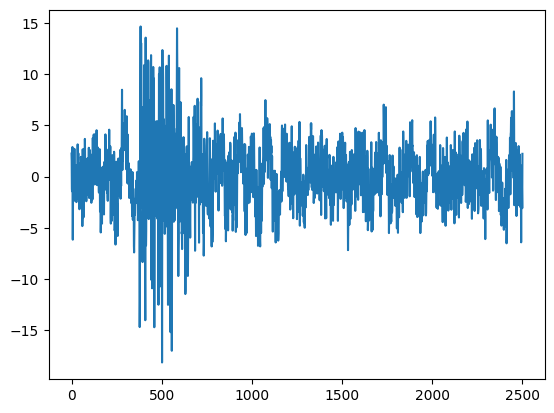

In [18]:
cat = pd.DataFrame({'event_ID':evID_list,
                    'otime':otimes_list,
                    'lat':lat_list,
                    'lon':lon_list,
                    'depth':depth_list}
                  )

cat['waveform'] = trace_ev_list

plt.plot(trace_ev_list[0])


In [19]:
# cat['waveform'] = trace_ev_list
# cat['otime'] = otimes_list
# cat['lat'] = lat_list
# cat['lon'] = lon_list
# cat['depth'] = depth_list
# plt.plot(trace_ev_list[0])

# Check lengths


In [20]:
# Check lengths

shapes =[len(s) for s in cat['waveform'] ]

if all(shape == 2501 for shape in shapes):
    print("All elements of shapes are equal to 2501")
else:
    print("Not all elements of shapes are equal to 2501")


indices_not_2501 = [i for i, shape in enumerate(shapes) if shape != 2501]

print("Indices where elements are not equal to 2501:", indices_not_2501)


All elements of shapes are equal to 2501
Indices where elements are not equal to 2501: []


# Plotting


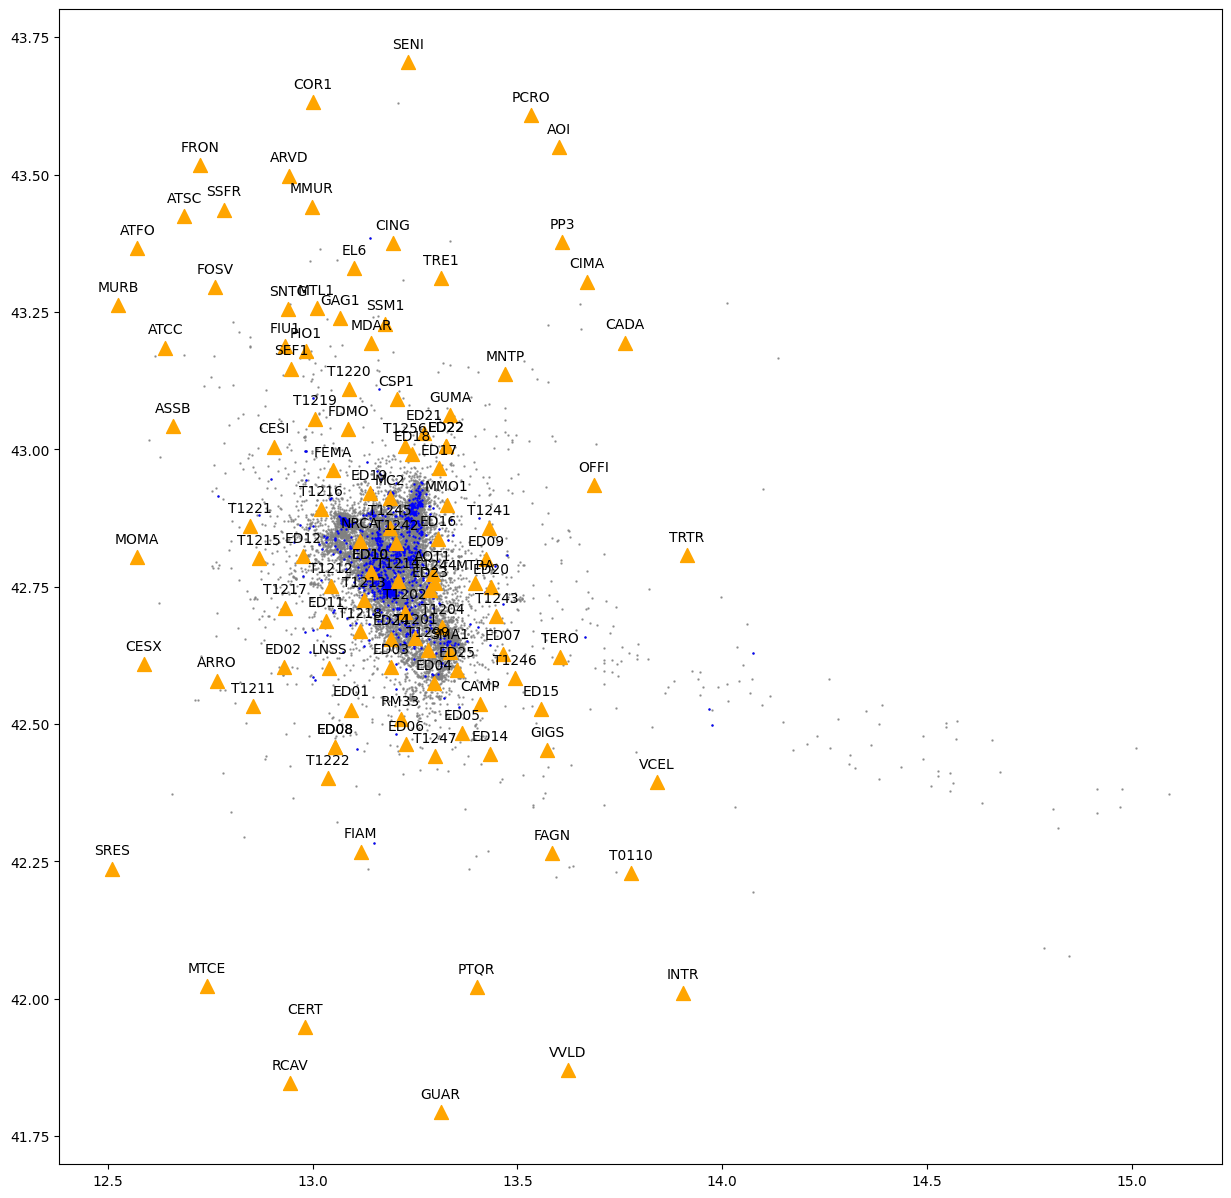

In [21]:
# Plotting

plt.figure(figsize=(15,15))
plt.scatter(df_events.lon,df_events.lat,s=.5,color='grey',alpha=.8)
plt.scatter(cat.lon,cat.lat,s=.5,color='blue')

plt.scatter(lon_sta_list,lat_sta_list,s=100,marker='^',c='orange')
# Add labels to each point
for i, txt in enumerate(name_sta_list):
    plt.annotate(txt, (lon_sta_list[i], lat_sta_list[i]), textcoords="offset points", xytext=(0,10), ha='center')
    
    if txt == station:
        plt.scatter(lon_sta_list[i],lat_sta_list[i],s=100,marker='^',c='red')
        
        

# Create H5 catalog

In [23]:
with h5py.File("./data/amatrice/waveforms_1000.h5", "w") as f:
    f.create_dataset("waveform", data=np.stack(cat["waveform"].values))
    f.create_dataset("event_ID", data=list(cat["event_ID"].values))
    f.create_dataset("otime", data=list(cat["otime"].astype('str').values))
    f.create_dataset("lat", data=list(cat["lat"].values))
    f.create_dataset("lon", data=list(cat["lon"].values))
    f.create_dataset("depth", data=list(cat["depth"].values))
    f.create_dataset("sampling_rate", data=fs)
